## Metodologías de Data Science - UPC
## Pipeline de Clasificación de Riesgo Crediticio

Se eligió un dataset de riesgo crediticio (ej. UCI German Credit Data, o similar) y establecer un flujo de trabajo de clasificación, investigar y justificar la elección entre la normalización (Min-Max Scaling) y la estandarización (Z-Score Scaling) para las variables numéricas, sensible a la escala (ej. K-Nearest Neighbors o SVM) y uno insensible a la escala (ej. Árbol de Decisión o Random Forest).

Realizar las siguientes actividades en un notebook de Python:

Realizar la imputación de valores perdidos y el One-Hot Encoding para variables categóricas.
Aplicar normalización a una copia del dataset y estandarización a otra copia.
Entrenar el modelo sensible a la escala con ambos conjuntos preprocesados y el modelo insensible a la escala con ambos conjuntos.
Comparar los cuatro resultados del modelo (Modelo A con Normalización vs. Estandarización; Modelo B con Normalización vs. Estandarización) usando la métrica F1-Score. Investiguen si existe sesgo entre los resultados.
Analizar y reportar cómo el preprocesamiento afecta el rendimiento de cada algoritmo.

1. Bibliotecas y Carga de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE

In [2]:
# Cargar dataset
df = pd.read_csv('data/german_credit_data.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [3]:
# Exploración inicial del dataset
print("Dimensiones del dataset:", df.shape)
print("\nInformación del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

Dimensiones del dataset: (1000, 10)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB
None

Estadísticas descriptivas:
        Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    32

In [4]:
# Verificar valores perdidos
print("Valores perdidos por columna:")
print(df.isnull().sum())
print("\nPorcentaje de valores perdidos:")
print((df.isnull().sum() / len(df) * 100).round(2))

Valores perdidos por columna:
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Porcentaje de valores perdidos:
Unnamed: 0           0.0
Age                  0.0
Sex                  0.0
Job                  0.0
Housing              0.0
Saving accounts     18.3
Checking account    39.4
Credit amount        0.0
Duration             0.0
Purpose              0.0
dtype: float64


In [5]:
print("Columnas disponibles:")
print(df.columns.tolist())

Columnas disponibles:
['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']


## 2. Análisis Exploratorio de Datos (EDA)

Variables numéricas: ['Unnamed: 0', 'Age', 'Job', 'Credit amount', 'Duration']


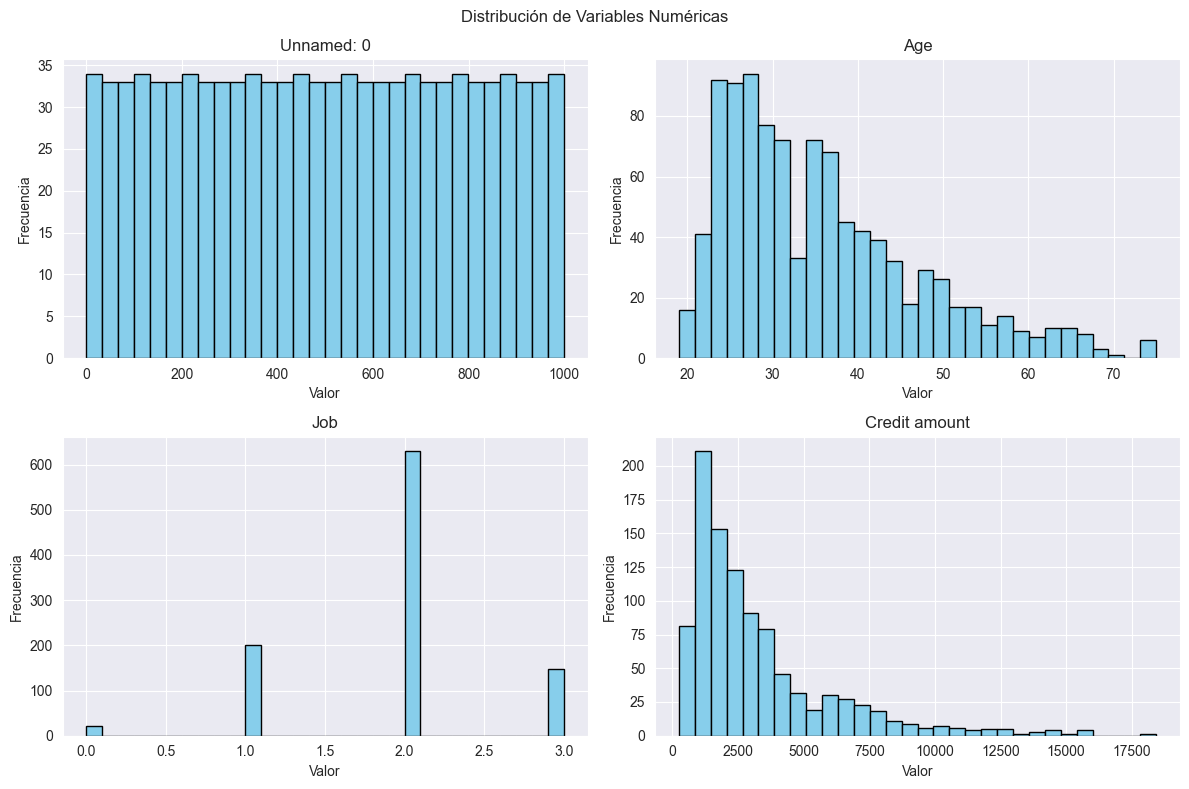

In [6]:
# Visualizar la distribución de variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Variables numéricas: {numeric_cols}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distribución de Variables Numéricas')

for idx, col in enumerate(numeric_cols[:4]):
    ax = axes[idx // 2, idx % 2]
    df[col].hist(bins=30, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Variables categóricas: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


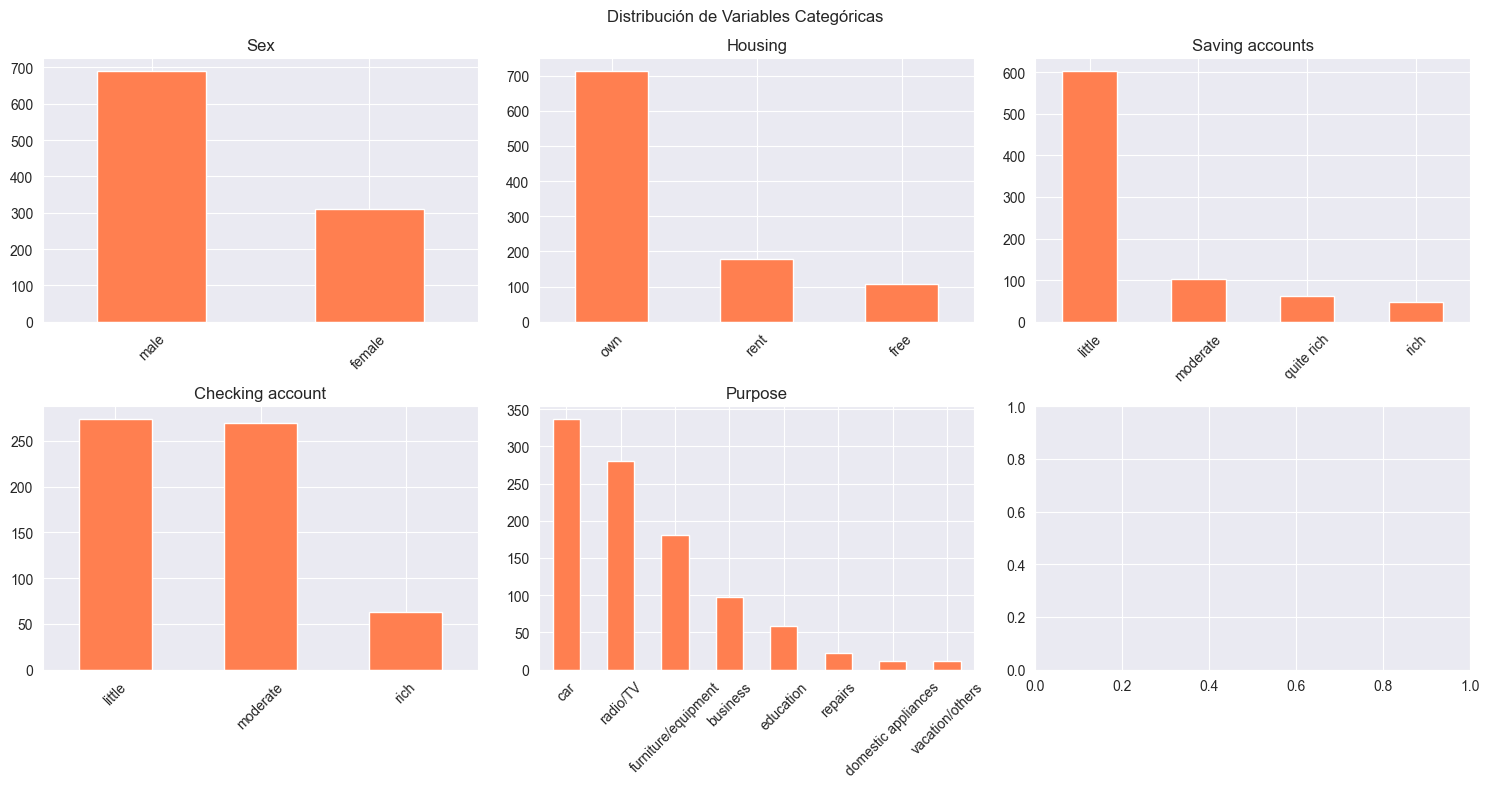

In [7]:
# Visualizar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categóricas: {categorical_cols}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribución de Variables Categóricas')
axes = axes.flatten()

for idx, col in enumerate(categorical_cols[:6]):
    df[col].value_counts().plot(kind='bar', ax=axes[idx], color='coral')
    axes[idx].set_title(col)
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Preprocesamiento de Datos

### 3.1 Manejo de Valores Perdidos

In [8]:
# Identificar columnas con valores perdidos (incluyendo 'NA' como string)
for col in df.columns:
    if df[col].dtype == 'object':
        na_count = (df[col] == 'NA').sum()
        if na_count > 0:
            print(f"{col}: {na_count} valores 'NA' ({na_count/len(df)*100:.2f}%)")

# Reemplazar 'NA' strings por NaN
df.replace('NA', np.nan, inplace=True)

# Verificar valores perdidos después del reemplazo
print("\nValores perdidos después de reemplazar 'NA':")
print(df.isnull().sum())


Valores perdidos después de reemplazar 'NA':
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


In [9]:
# Estrategia de imputación:
# - Variables numéricas: imputar con la mediana
# - Variables categóricas: imputar con la moda

from sklearn.impute import SimpleImputer

# Separar columnas numéricas y categóricas
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numéricas: {numeric_features}")
print(f"Variables categóricas: {categorical_features}")

# Crear copia del dataframe para trabajar
df_imputed = df.copy()

# Imputar valores numéricos con la mediana
if numeric_features:
    imputer_num = SimpleImputer(strategy='median')
    df_imputed[numeric_features] = imputer_num.fit_transform(df_imputed[numeric_features])

# Imputar valores categóricos con la moda
if categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_imputed[categorical_features] = imputer_cat.fit_transform(df_imputed[categorical_features])

print("\nValores perdidos después de la imputación:")
print(df_imputed.isnull().sum())

Variables numéricas: ['Unnamed: 0', 'Age', 'Job', 'Credit amount', 'Duration']
Variables categóricas: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

Valores perdidos después de la imputación:
Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64


### 3.2 Codificación de Variables Categóricas (One-Hot Encoding)

In [10]:
# Aplicar One-Hot Encoding a las variables categóricas
# Excluir la primera columna (índice) si existe
if 'Unnamed: 0' in df_imputed.columns:
    df_imputed = df_imputed.drop('Unnamed: 0', axis=1)


print("Primeras filas después de imputación:")
print(df_imputed.head())

Primeras filas después de imputación:
    Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0  67.0    male  2.0     own          little           little         1169.0   
1  22.0  female  2.0     own          little         moderate         5951.0   
2  49.0    male  1.0     own          little           little         2096.0   
3  45.0    male  2.0    free          little           little         7882.0   
4  53.0    male  2.0    free          little           little         4870.0   

   Duration              Purpose  
0       6.0             radio/TV  
1      48.0             radio/TV  
2      12.0            education  
3      42.0  furniture/equipment  
4      24.0                  car  


In [11]:
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_imputed, columns=categorical_features, drop_first=True)

print(f"Dimensiones después de One-Hot Encoding: {df_encoded.shape}")
print(f"Nuevas columnas creadas: {df_encoded.shape[1] - df_imputed.shape[1]}")
print("\nPrimeras columnas del dataset codificado:")
print(df_encoded.columns.tolist()[:20])

Dimensiones después de One-Hot Encoding: (1000, 19)
Nuevas columnas creadas: 10

Primeras columnas del dataset codificado:
['Age', 'Job', 'Credit amount', 'Duration', 'Sex_male', 'Housing_own', 'Housing_rent', 'Saving accounts_moderate', 'Saving accounts_quite rich', 'Saving accounts_rich', 'Checking account_moderate', 'Checking account_rich', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others']


### 3.3 Separación de Variables y Target

Para este ejercicio, vamos a predecir el riesgo crediticio basado en las características disponibles.
Crearemos una variable target basada en el monto del crédito y la duración.

Distribución de la variable objetivo (Risk):
Risk
0    650
1    350
Name: count, dtype: int64

Porcentaje:
Risk
0    65.0
1    35.0
Name: proportion, dtype: float64


C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19956\282690301.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk', data=df_encoded, palette='viridis')


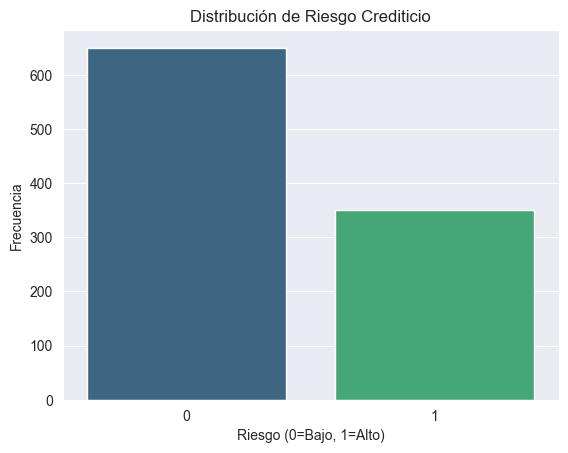

In [12]:

threshold_duration = df_encoded['Duration'].median()
threshold_credit = df_encoded['Credit amount'].median()

# Riesgo alto = 1, Riesgo bajo = 0
df_encoded['Risk'] = ((df_encoded['Duration'] > threshold_duration) &
                      (df_encoded['Credit amount'] > threshold_credit)).astype(int)

print("Distribución de la variable objetivo (Risk):")
print(df_encoded['Risk'].value_counts())
print("\nPorcentaje:")
print(df_encoded['Risk'].value_counts(normalize=True) * 100)

# Visualizar distribución
sns.countplot(x='Risk', data=df_encoded, palette='viridis')
plt.title('Distribución de Riesgo Crediticio')
plt.xlabel('Riesgo (0=Bajo, 1=Alto)')
plt.ylabel('Frecuencia')
plt.show()

In [13]:
# Separar x e y
X = df_encoded.drop('Risk', axis=1)
y = df_encoded['Risk']

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

Dimensiones de X: (1000, 19)
Dimensiones de y: (1000,)


## 4. Aplicar Normalización y Estandarización

Crearemos dos copias del dataset:
- **Copia 1**: Con **Normalización (Min-Max Scaling)** - escala los valores entre 0 y 1
- **Copia 2**: Con **Estandarización (Z-Score)** - centra los datos con media 0 y desviación estándar 1

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")
print(f"\nDistribución en train: {y_train.value_counts().to_dict()}")
print(f"Distribución en test: {y_test.value_counts().to_dict()}")

Conjunto de entrenamiento: (800, 19)
Conjunto de prueba: (200, 19)

Distribución en train: {0: 520, 1: 280}
Distribución en test: {0: 130, 1: 70}


In [15]:
# COPIA 1: Normalización (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
X_train_normalized = scaler_minmax.fit_transform(X_train)
X_test_normalized = scaler_minmax.transform(X_test)

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns, index=X_test.index)

print("Dataset Normalizado (Min-Max):")
print(X_train_normalized.describe())

Dataset Normalizado (Min-Max):
              Age         Job  Credit amount    Duration    Sex_male  \
count  800.000000  800.000000     800.000000  800.000000  800.000000   
mean     0.297254    0.632917       0.161795    0.299978    0.683750   
std      0.206710    0.218972       0.149840    0.212096    0.465303   
min      0.000000    0.000000       0.000000    0.000000    0.000000   
25%      0.142857    0.666667       0.060034    0.142857    0.000000   
50%      0.250000    0.666667       0.112602    0.250000    1.000000   
75%      0.410714    0.666667       0.203673    0.357143    1.000000   
max      1.000000    1.000000       1.000000    1.000000    1.000000   

       Housing_own  Housing_rent  Saving accounts_moderate  \
count   800.000000    800.000000                800.000000   
mean      0.711250      0.175000                  0.098750   
std       0.453465      0.380205                  0.298513   
min       0.000000      0.000000                  0.000000   
25%       

In [16]:
# COPIA 2: Estandarización (Z-Score)
scaler_standard = StandardScaler()
X_train_standardized = scaler_standard.fit_transform(X_train)
X_test_standardized = scaler_standard.transform(X_test)

# Convertir de vuelta a DataFrame
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns, index=X_train.index)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns, index=X_test.index)

print("Dataset Estandarizado (Z-Score):")
print(X_train_standardized.describe())

Dataset Estandarizado (Z-Score):
                Age           Job  Credit amount      Duration      Sex_male  \
count  8.000000e+02  8.000000e+02   8.000000e+02  8.000000e+02  8.000000e+02   
mean  -1.798561e-16  9.769963e-17  -3.996803e-17  1.276756e-16  3.330669e-17   
std    1.000626e+00  1.000626e+00   1.000626e+00  1.000626e+00  1.000626e+00   
min   -1.438924e+00 -2.892211e+00  -1.080459e+00 -1.415233e+00 -1.470393e+00   
25%   -7.473934e-01  1.542259e-01  -6.795537e-01 -7.412625e-01 -1.470393e+00   
50%   -2.287454e-01  1.542259e-01  -3.285086e-01 -2.357845e-01  6.800903e-01   
75%    5.492266e-01  1.542259e-01   2.796567e-01  2.696936e-01  6.800903e-01   
max    3.401791e+00  1.677444e+00   5.597493e+00  3.302562e+00  6.800903e-01   

        Housing_own  Housing_rent  Saving accounts_moderate  \
count  8.000000e+02  8.000000e+02              8.000000e+02   
mean  -7.993606e-17  4.440892e-18             -2.442491e-17   
std    1.000626e+00  1.000626e+00              1.000626e+

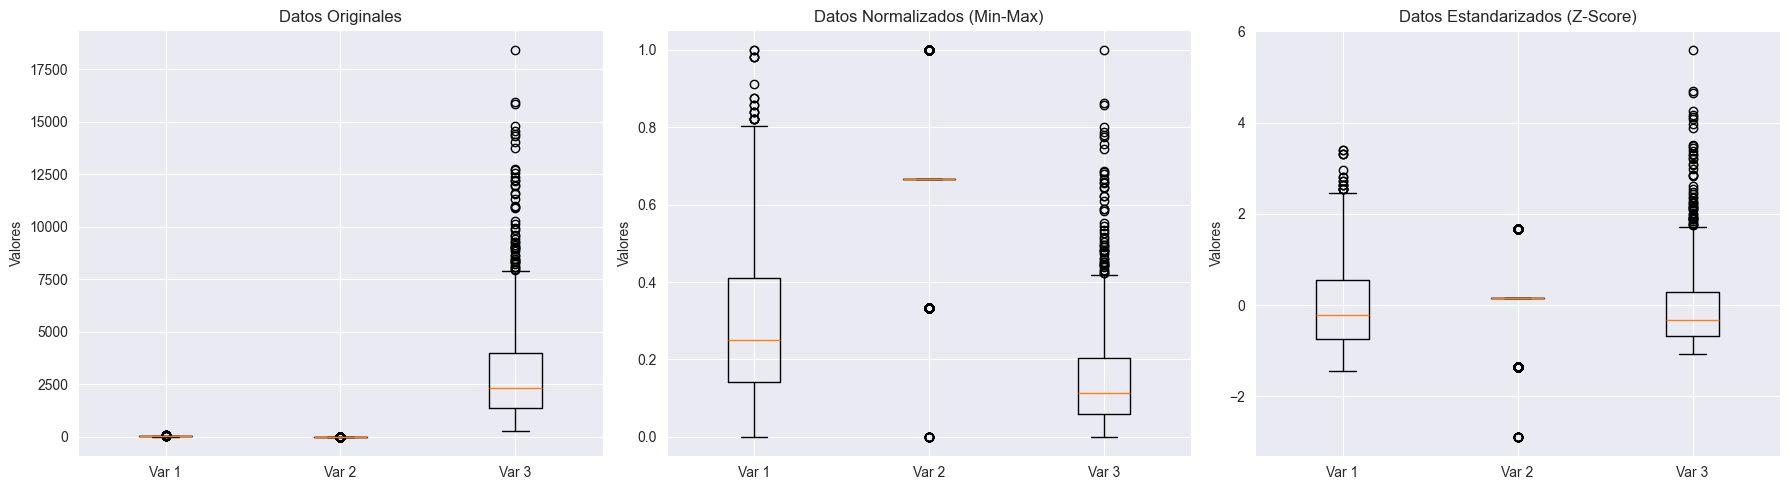

In [17]:
# Comparación visual de las escalas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset original
axes[0].boxplot([X_train.iloc[:, 0], X_train.iloc[:, 1], X_train.iloc[:, 2]])
axes[0].set_title('Datos Originales')
axes[0].set_ylabel('Valores')
axes[0].set_xticklabels(['Var 1', 'Var 2', 'Var 3'])

# Dataset normalizado
axes[1].boxplot([X_train_normalized.iloc[:, 0], X_train_normalized.iloc[:, 1], X_train_normalized.iloc[:, 2]])
axes[1].set_title('Datos Normalizados (Min-Max)')
axes[1].set_ylabel('Valores')
axes[1].set_xticklabels(['Var 1', 'Var 2', 'Var 3'])

# Dataset estandarizado
axes[2].boxplot([X_train_standardized.iloc[:, 0], X_train_standardized.iloc[:, 1], X_train_standardized.iloc[:, 2]])
axes[2].set_title('Datos Estandarizados (Z-Score)')
axes[2].set_ylabel('Valores')
axes[2].set_xticklabels(['Var 1', 'Var 2', 'Var 3'])

plt.tight_layout()
plt.show()

MODELO A: K-NEAREST NEIGHBORS CON NORMALIZACIÓN (Min-Max)

F1-Score: 0.6718

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       130
           1       0.72      0.63      0.67        70

    accuracy                           0.79       200
   macro avg       0.77      0.75      0.76       200
weighted avg       0.78      0.79      0.78       200



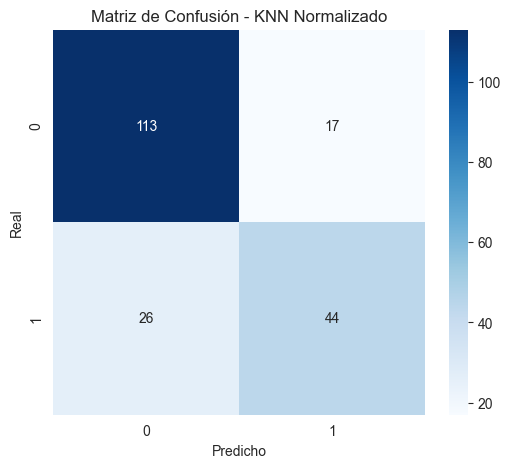

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# KNN con datos NORMALIZADOS
print("="*60)
print("MODELO A: K-NEAREST NEIGHBORS CON NORMALIZACIÓN (Min-Max)")
print("="*60)

knn_normalized = KNeighborsClassifier(n_neighbors=5)
knn_normalized.fit(X_train_normalized, y_train)
y_pred_knn_norm = knn_normalized.predict(X_test_normalized)

f1_knn_norm = f1_score(y_test, y_pred_knn_norm)
print(f"\nF1-Score: {f1_knn_norm:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_knn_norm))

# Matriz de confusión
cm_knn_norm = confusion_matrix(y_test, y_pred_knn_norm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn_norm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - KNN Normalizado')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

MODELO A: K-NEAREST NEIGHBORS CON ESTANDARIZACIÓN (Z-Score)

F1-Score: 0.7647

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       130
           1       0.79      0.74      0.76        70

    accuracy                           0.84       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.84      0.84      0.84       200



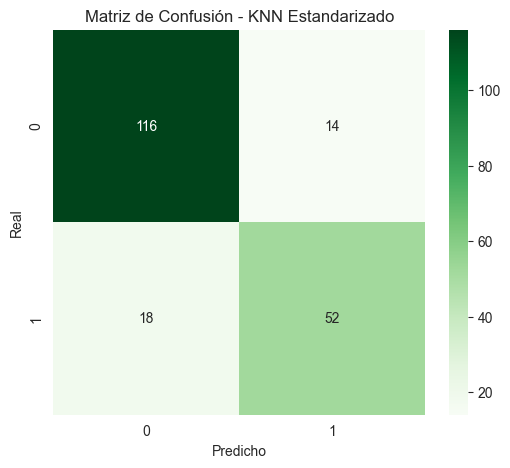

In [19]:
# KNN con datos ESTANDARIZADOS
print("="*60)
print("MODELO A: K-NEAREST NEIGHBORS CON ESTANDARIZACIÓN (Z-Score)")
print("="*60)

knn_standardized = KNeighborsClassifier(n_neighbors=5)
knn_standardized.fit(X_train_standardized, y_train)
y_pred_knn_std = knn_standardized.predict(X_test_standardized)

f1_knn_std = f1_score(y_test, y_pred_knn_std)
print(f"\nF1-Score: {f1_knn_std:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_knn_std))

# Matriz de confusión
cm_knn_std = confusion_matrix(y_test, y_pred_knn_std)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn_std, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - KNN Estandarizado')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

### 5.2 Modelo B: Random Forest (Insensible a escala)

MODELO B: RANDOM FOREST CON NORMALIZACIÓN (Min-Max)

F1-Score: 0.9928

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       130
           1       1.00      0.99      0.99        70

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



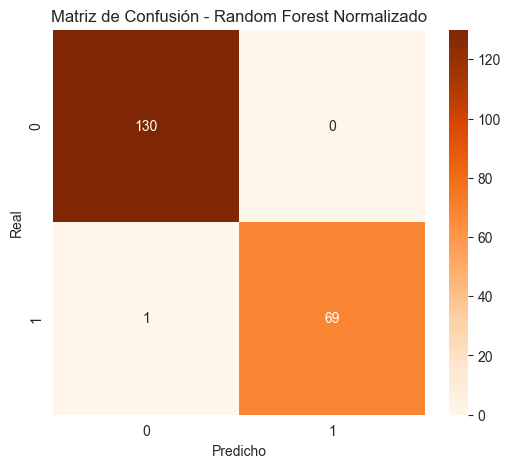

In [20]:
# Random Forest con datos NORMALIZADOS
print("="*60)
print("MODELO B: RANDOM FOREST CON NORMALIZACIÓN (Min-Max)")
print("="*60)

rf_normalized = RandomForestClassifier(n_estimators=100, random_state=42)
rf_normalized.fit(X_train_normalized, y_train)
y_pred_rf_norm = rf_normalized.predict(X_test_normalized)

f1_rf_norm = f1_score(y_test, y_pred_rf_norm)
print(f"\nF1-Score: {f1_rf_norm:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf_norm))

# Matriz de confusión
cm_rf_norm = confusion_matrix(y_test, y_pred_rf_norm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_norm, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - Random Forest Normalizado')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

MODELO B: RANDOM FOREST CON ESTANDARIZACIÓN (Z-Score)

F1-Score: 0.9928

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       130
           1       1.00      0.99      0.99        70

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



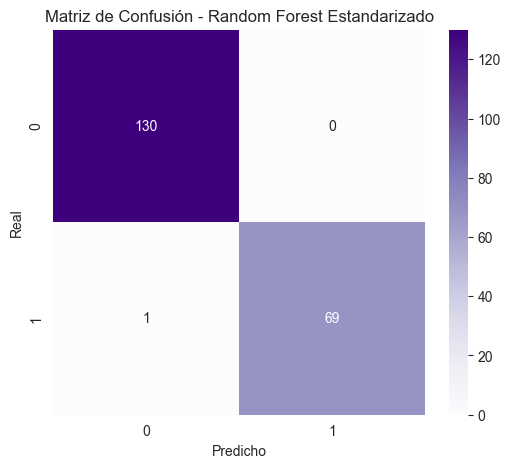

In [21]:
# Random Forest con datos ESTANDARIZADOS
print("="*60)
print("MODELO B: RANDOM FOREST CON ESTANDARIZACIÓN (Z-Score)")
print("="*60)

rf_standardized = RandomForestClassifier(n_estimators=100, random_state=42)
rf_standardized.fit(X_train_standardized, y_train)
y_pred_rf_std = rf_standardized.predict(X_test_standardized)

f1_rf_std = f1_score(y_test, y_pred_rf_std)
print(f"\nF1-Score: {f1_rf_std:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf_std))

# Matriz de confusión
cm_rf_std = confusion_matrix(y_test, y_pred_rf_std)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_std, annot=True, fmt='d', cmap='Purples')
plt.title('Matriz de Confusión - Random Forest Estandarizado')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 6. Comparación de Resultados y Análisis

### 6.1 Tabla Comparativa de F1-Scores

In [22]:
# Crear tabla comparativa de resultados
from sklearn.metrics import accuracy_score, precision_score, recall_score

results_comparison = pd.DataFrame({
    'Modelo': [
        'KNN - Normalizado',
        'KNN - Estandarizado',
        'Random Forest - Normalizado',
        'Random Forest - Estandarizado'
    ],
    'Preprocesamiento': ['Min-Max', 'Z-Score', 'Min-Max', 'Z-Score'],
    'F1-Score': [f1_knn_norm, f1_knn_std, f1_rf_norm, f1_rf_std],
    'Accuracy': [
        accuracy_score(y_test, y_pred_knn_norm),
        accuracy_score(y_test, y_pred_knn_std),
        accuracy_score(y_test, y_pred_rf_norm),
        accuracy_score(y_test, y_pred_rf_std)
    ],
    'Precision': [
        precision_score(y_test, y_pred_knn_norm, zero_division=0),
        precision_score(y_test, y_pred_knn_std, zero_division=0),
        precision_score(y_test, y_pred_rf_norm, zero_division=0),
        precision_score(y_test, y_pred_rf_std, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_knn_norm, zero_division=0),
        recall_score(y_test, y_pred_knn_std, zero_division=0),
        recall_score(y_test, y_pred_rf_norm, zero_division=0),
        recall_score(y_test, y_pred_rf_std, zero_division=0)
    ]
})

print("="*80)
print("COMPARACIÓN DE RESULTADOS - TODOS LOS MODELOS")
print("="*80)
print(results_comparison.to_string(index=False))

COMPARACIÓN DE RESULTADOS - TODOS LOS MODELOS
                       Modelo Preprocesamiento  F1-Score  Accuracy  Precision   Recall
            KNN - Normalizado          Min-Max  0.671756     0.785   0.721311 0.628571
          KNN - Estandarizado          Z-Score  0.764706     0.840   0.787879 0.742857
  Random Forest - Normalizado          Min-Max  0.992806     0.995   1.000000 0.985714
Random Forest - Estandarizado          Z-Score  0.992806     0.995   1.000000 0.985714


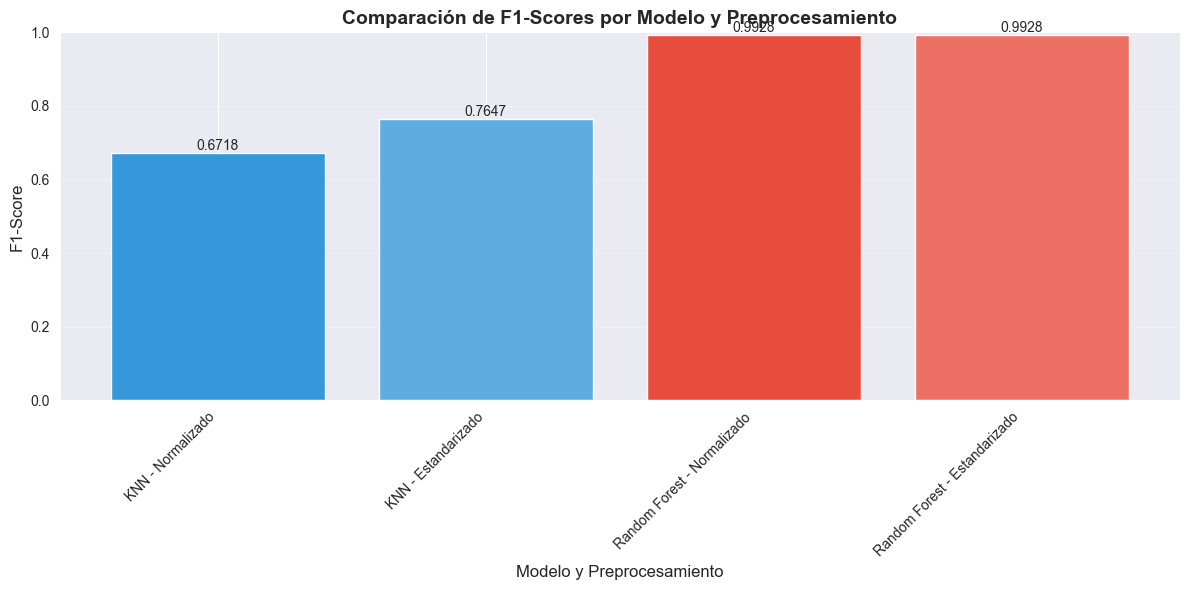

In [23]:
# Visualización comparativa de F1-Scores
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_comparison))
width = 0.35

colors_norm = ['#3498db', '#e74c3c']
colors_std = ['#5dade2', '#ec7063']

bars = ax.bar(x, results_comparison['F1-Score'],
              color=[colors_norm[0], colors_std[0], colors_norm[1], colors_std[1]])

ax.set_xlabel('Modelo y Preprocesamiento', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Comparación de F1-Scores por Modelo y Preprocesamiento', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_comparison['Modelo'], rotation=45, ha='right')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

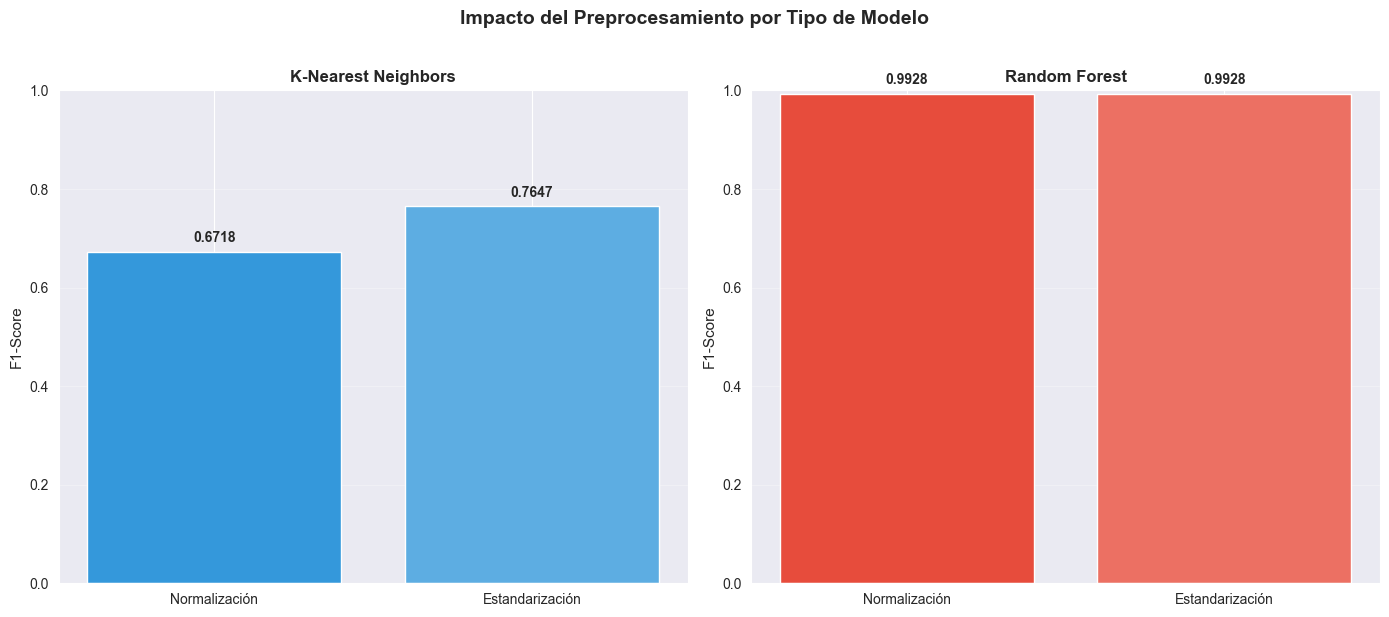

In [24]:
# Gráfico de barras agrupadas por tipo de modelo
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KNN
knn_scores = [f1_knn_norm, f1_knn_std]
axes[0].bar(['Normalización', 'Estandarización'], knn_scores, color=['#3498db', '#5dade2'])
axes[0].set_title('K-Nearest Neighbors', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1-Score', fontsize=11)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(knn_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Random Forest
rf_scores = [f1_rf_norm, f1_rf_std]
axes[1].bar(['Normalización', 'Estandarización'], rf_scores, color=['#e74c3c', '#ec7063'])
axes[1].set_title('Random Forest', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=11)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rf_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.suptitle('Impacto del Preprocesamiento por Tipo de Modelo', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()